<a href="https://colab.research.google.com/github/pranav168/NYC-Taxi-Trip-Time-Prediction/blob/main/Copy_of_NYC_Taxi_Trip_Time_Prediction_final_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing all the required packages and libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt
!pip install haversine
import haversine as hs
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
!pip install catboost
from catboost import CatBoostRegressor

from mpl_toolkits.mplot3d import axes3d
from sklearn.metrics import r2_score,accuracy_score  
from sklearn.model_selection import train_test_split  
from xgboost import XGBRegressor
from sklearn import metrics
import warnings                                                                 # Removing all those annoying Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


     |████████████████████████████████| 67.4 MB 27 kB/s 


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Copy of NYC Taxi Data.csv') 
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
df.info()                                                                       #No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
column_list=['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration']
count_dataset=pd.DataFrame()
distinct_features=[]                                                                                          #Empty list to know the number of distict features,sum of all these values, and sum of values top 10 comprises
for i in column_list:                                                                                               
  count_dataset[i]= pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).index)      
  count_dataset[f'{i}_count']=pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).values).astype('int')   
  distinct_features.append((len(df[i].value_counts().index),df[i].value_counts().sum(),df[i].value_counts().sort_values(ascending=False).head(10).sum())) 
# final_tally=list(zip(column_list,distinct_features))                                                           #Zipping with column_list
col_ref={}  
for i in column_list:
  if i in ['trip_duration']:                                                                    #colur red shows the Dependent Variable('trip_duration')
    col_ref[i]='background-color: red'  
  else:
    col_ref[i]='background-color: blue'                                                                       #colur blue shows the features 
  temp=f'{i}_count'
  col_ref[temp]='background-color: green'                                                                     #colur green shows the count
def Nan_as_black(val):
  if str(val)=='nan':
    color = 'black'
    return 'color: %s' % color
count_dataset=count_dataset.style.apply(lambda x: pd.DataFrame(col_ref, index=count_dataset.index, columns=count_dataset.columns).fillna(''), axis=None).highlight_null('black').applymap(Nan_as_black)
count_dataset

,id,id_count,vendor_id,vendor_id_count,pickup_datetime,pickup_datetime_count,dropoff_datetime,dropoff_datetime_count,passenger_count,passenger_count_count,pickup_longitude,pickup_longitude_count,pickup_latitude,pickup_latitude_count,dropoff_longitude,dropoff_longitude_count,dropoff_latitude,dropoff_latitude_count,store_and_fwd_flag,store_and_fwd_flag_count,trip_duration,trip_duration_count
0,id0290975,1,2.000000,780302.000000,2016-01-12 18:48:44,5,2016-05-16 19:40:28,5,1,1033540,-73.982201,633,40.774101,414,-73.982330,443,40.774311,269,N,1450599.000000,368,1624
1,id2060444,1,1.000000,678342.000000,2016-05-07 13:18:07,5,2016-02-19 19:25:04,5,2,210318,-73.982140,607,40.774090,411,-73.982094,433,40.774330,263,Y,8045.000000,408,1584
2,id3875012,1,nan,nan,2016-04-05 18:55:21,5,2016-02-28 02:41:12,4,5,78088,-73.982101,587,40.774120,410,-73.982246,430,40.750149,259,nan,nan,348,1582
3,id3654481,1,nan,nan,2016-06-10 23:17:17,5,2016-03-04 19:33:28,4,3,59896,-73.982117,585,40.774109,392,-73.982117,427,40.750118,253,nan,nan,367,1581
4,id1342396,1,nan,nan,2016-03-04 08:07:34,5,2016-02-07 15:35:02,4,6,48333,-73.982224,584,40.774078,390,-73.991379,420,40.750198,250,nan,nan,358,1577
5,id0424790,1,nan,nan,2016-02-09 21:03:38,5,2016-05-03 18:27:19,4,4,28404,-73.982094,575,40.774052,376,-73.982201,419,40.750172,247,nan,nan,399,1573
6,id1573751,1,nan,nan,2016-06-15 22:28:10,4,2016-03-30 22:12:02,4,0,60,-73.982246,558,40.774132,356,-73.982269,414,40.774319,245,nan,nan,418,1570
7,id0113927,1,nan,nan,2016-06-29 13:13:50,4,2016-04-10 20:01:29,4,7,3,-73.982208,551,40.774139,352,-73.991402,406,40.774342,244,nan,nan,417,1568
8,id2863653,1,nan,nan,2016-03-19 22:28:48,4,2016-03-03 20:20:32,4,8,1,-73.982307,546,40.774071,347,-73.982384,405,40.750038,242,nan,nan,388,1567
9,id1964522,1,nan,nan,2016-06-09 19:59:43,4,2016-06-05 14:10:03,4,9,1,-73.982239,545,40.774158,335,-73.982307,403,40.750111,242,nan,nan,344,1561


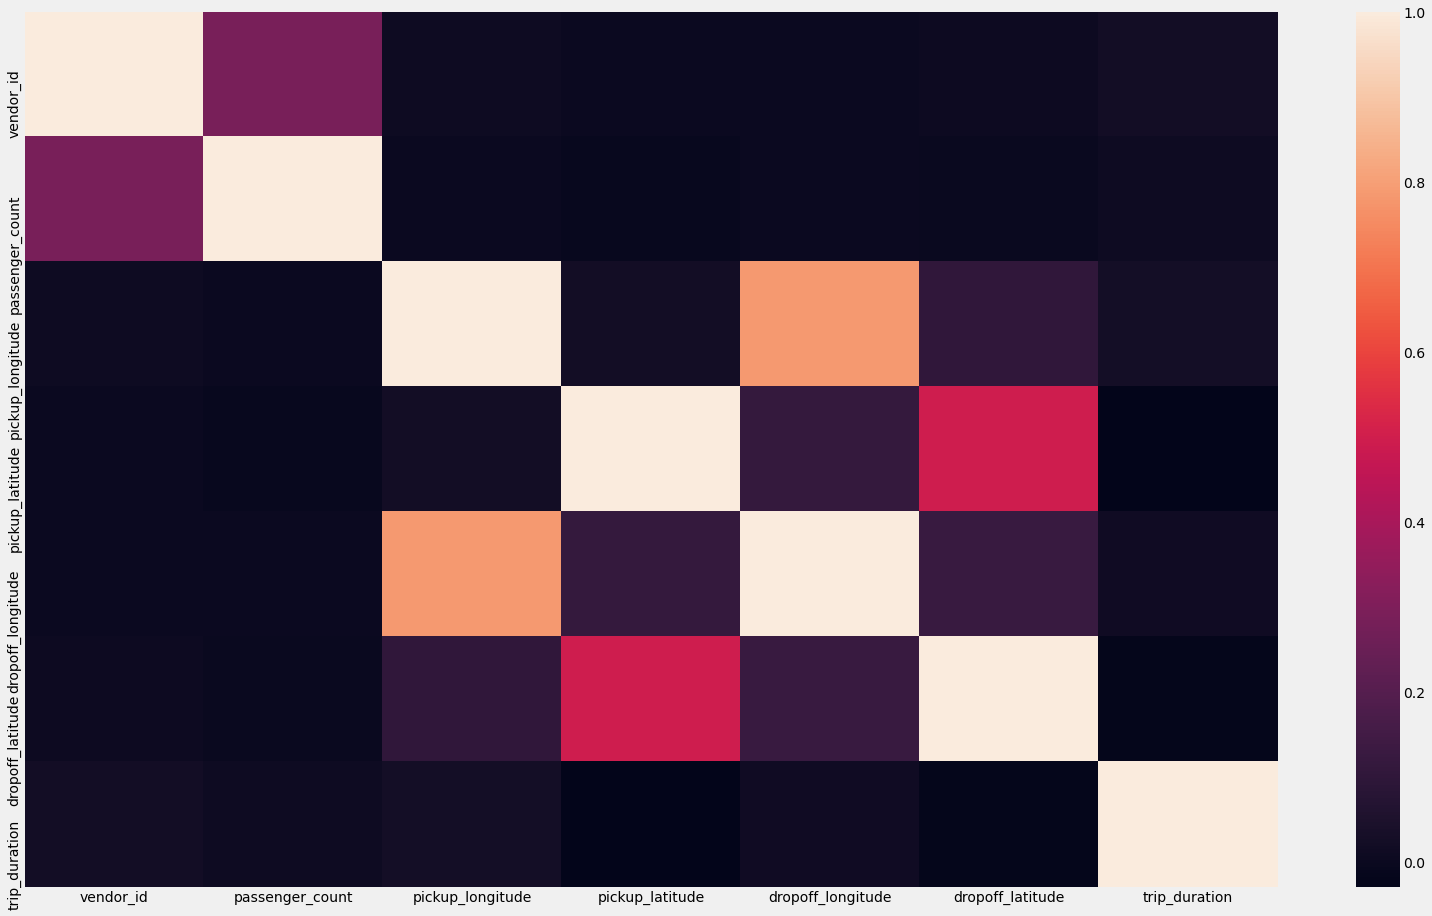

In [ ]:
corr = df.corr()                                                                #plotting co-relation chart
plt.figure(figsize=(25,15))
sns.heatmap(corr, annot=False)
plt.show()                                                                      #there is no correlation whatsoever between our dependent and independent variables, thus i will be making various features to improve this situation                                            

In [ ]:
df.describe()                                                                   #their are few cases with passanger count 0, lets explore it
                                                                                #also minimum drip duretion is 1 sec which show an anomaly, lets remove them first
                                                                                # Minimum pickup and dropoff longitude are really low than mean

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
df=df[df.passenger_count!=0]                                                    #Removing rows with 0 passenger count                                      

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')                 #Converting these dates to datetime format
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [ ]:
print(np.percentile(df.trip_duration,0.1),
np.percentile(df.trip_duration,0.5),
np.percentile(df.trip_duration,1.5),                                            #after this the value starts to get saturated thus anything below 107 sec is mostly a outlier, now lets look for maximum value as well
np.percentile(df.trip_duration,2),
np.percentile(df.trip_duration,2.5),
np.percentile(df.trip_duration,3),
np.percentile(df.trip_duration,3.5))

7.0 51.0 107.0 122.0 135.0 146.0 156.0


In [ ]:
print(np.percentile(df.trip_duration,98.5),
np.percentile(df.trip_duration,99),
np.percentile(df.trip_duration,99.5),                                           #after this the value starts to get increase suddenly thus anything above 4139 sec is mostly a outlier, lets remove these values
np.percentile(df.trip_duration,99.9))

3072.0 3440.0 4139.0 85127.41700000013


In [ ]:
df=df[(df.trip_duration>=107) & (df.trip_duration<=4139)]

In [ ]:
print(np.percentile(df.pickup_longitude,0.1),
      np.percentile(df.pickup_longitude,0.05),                                  #after this their is anomaly 
      np.percentile(df.pickup_longitude,0.01),                                                                  
      np.percentile(df.pickup_longitude,0.001),
      np.percentile(df.pickup_longitude,0.0001))
df=df[df.pickup_longitude>-74.017]
print(np.percentile(df.dropoff_longitude,0.1),
      np.percentile(df.dropoff_longitude,0.05),
      np.percentile(df.dropoff_longitude,0.01),                                 #after this their is anomaly                                 
      np.percentile(df.dropoff_longitude,0.001),
      np.percentile(df.dropoff_longitude,0.0001))
df=df[df.dropoff_longitude>=-74.467]

-74.01712036132812 -74.01737976074219 -74.07968558120727 -74.35324770942688 -103.73459467295076
-74.17746734619139 -74.18138921356203 -74.18852077331543 -74.46795725708009 -79.53859309568787


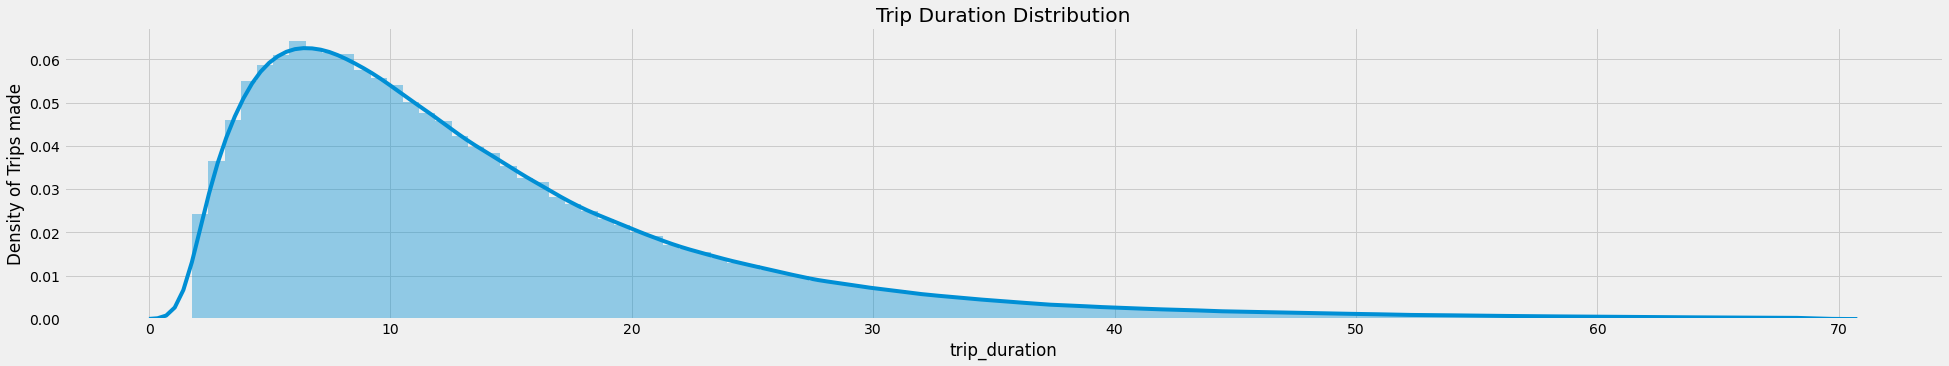

In [ ]:
plt.figure(figsize=(30,5))
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration, minutes')
plt.ylabel('Density of Trips made')
sns.distplot(df.trip_duration/60, bins=100)

In [ ]:
#adding another column with distance metric calculted using lat and long 
df['haversine distance (km)'] = df.apply(lambda x: float(hs.haversine((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'], x['dropoff_longitude']))),axis=1)
df.shape

(1427892, 12)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()                                                                   #Data looks Perfect now,still their can be some relative anomalies, which i will remove using isolation forest                      

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,haversine distance (km)
count,1427892.000,1427892.000,1427892.000,1427892.000,1427892.000,1427892.000,1427892.000,1427892.000
mean,1.535,1.666,-73.974,40.751,-73.974,40.752,833.573,3.428
std,0.499,1.315,0.041,0.031,0.039,0.034,607.683,4.004
min,1.000,1.000,-74.017,34.360,-74.455,34.360,107.000,0.000
25%,1.000,1.000,-73.992,40.738,-73.991,40.736,407.000,1.262
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,668.000,2.118
75%,2.000,2.000,-73.968,40.768,-73.963,40.770,1075.000,3.887
max,2.000,9.000,-61.336,51.881,-61.336,43.912,4139.000,1240.910


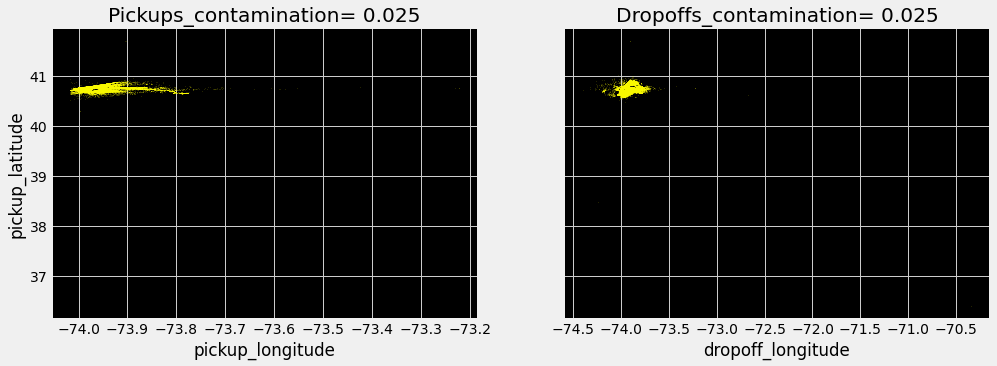

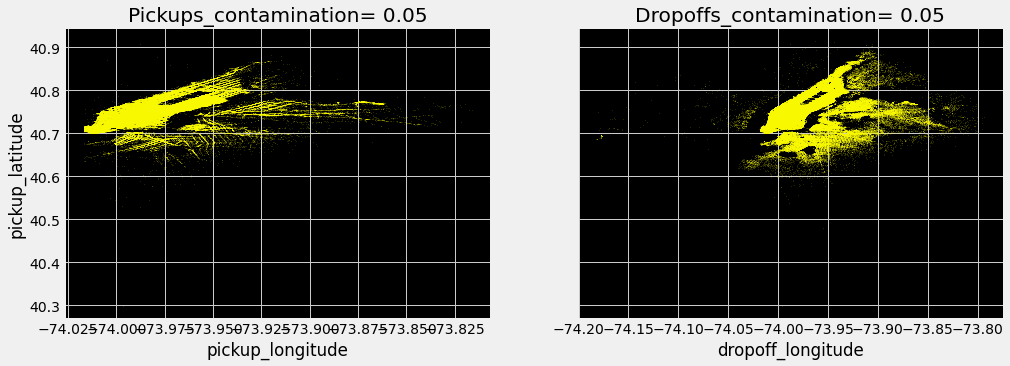

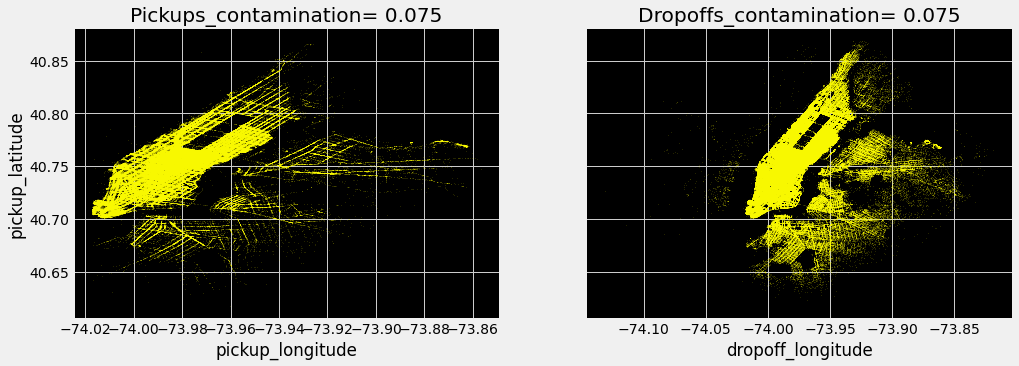

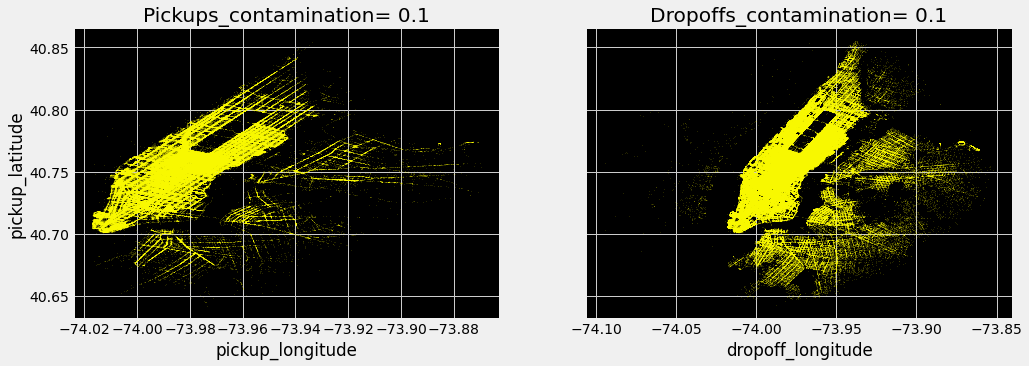

In [ ]:
minmax = MinMaxScaler(feature_range=(0, 1))                                     #Using Isolation Forest algorithm for anomaly detection, for contamination i will use various values and visualize the best scatter plot
X = minmax.fit_transform(df[['trip_duration','haversine distance (km)','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']])
contamination_list=[0.025,0.05,0.075,0.1]
for contamination in contamination_list:
  clf = IsolationForest(n_estimators=100, contamination=contamination, random_state=0)      
  try:
    clf.fit(X)
  except:
    pass
  temp=df
  temp['multivariate_outlier'] = clf.predict(X)                                   # prediction of a datapoint category outlier or inlier
  temp=temp[temp.multivariate_outlier==1]                                             #removing these outliers
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))

  temp.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                  color='yellow', 
                  s=.02, alpha=.6, subplots=True, ax=ax1)
  ax1.set_title(f"Pickups_contamination= {contamination}")
  ax1.set_facecolor('black')

  temp.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                  color='yellow', 
                  s=.02, alpha=.6, subplots=True, ax=ax2)
  ax2.set_title(f"Dropoffs_contamination= {contamination}")
  ax2.set_facecolor('black') 
  plt.show()

In [ ]:
'''Thus contamination=0.075 works best as we want to retain maximum amount of data'''
minmax = MinMaxScaler(feature_range=(0, 1))                                     #Using Isolation Forest algorithm for anomaly detection, for contamination i will use various values and visualize the best scatter plot
X = minmax.fit_transform(df[['trip_duration','haversine distance (km)','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']])
clf = IsolationForest(n_estimators=100, contamination=0.075, random_state=0)      
clf.fit(X)
df['multivariate_outlier'] = clf.predict(X)                                     # prediction of a datapoint category outlier or inlier
df=df[df.multivariate_outlier==1]  
df.drop('multivariate_outlier',axis=1,inplace=True)

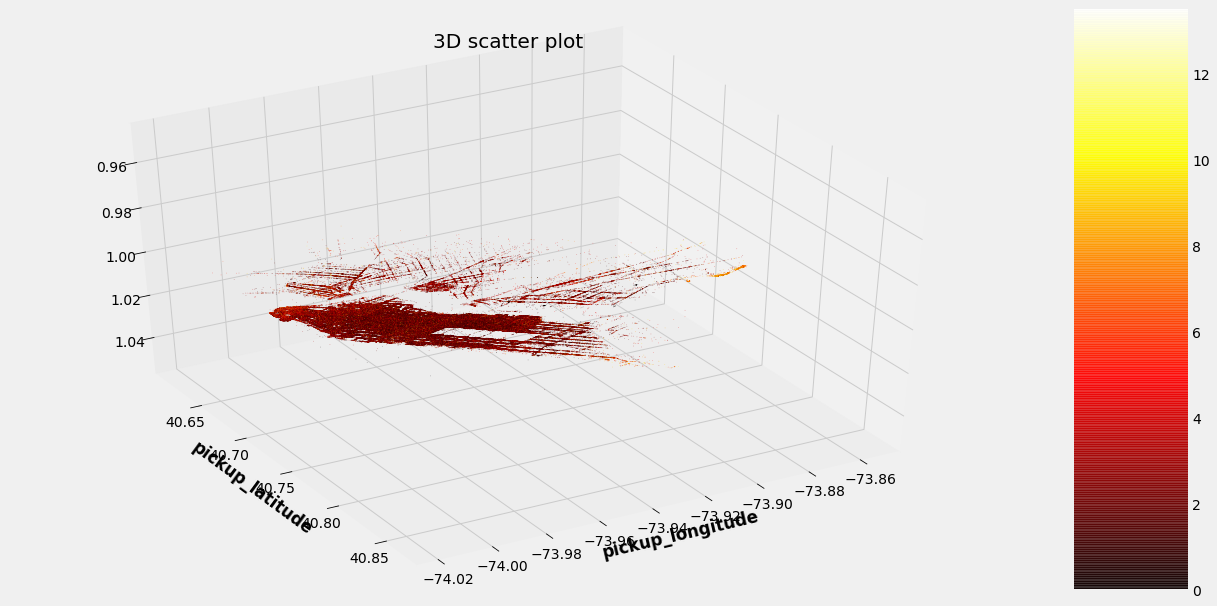

In [ ]:
def plot_scatter(df):                                                           
  fig = plt.figure(figsize = (20, 10))
  ax = plt.axes(projection ="3d")
  # Creating color map
  z=range(1,len(df['pickup_longitude'])+1)
  Z=[]
  count=0
  my_cmap = plt.get_cmap('hot')
  plot=ax.scatter3D(df['pickup_longitude'],df['pickup_latitude'],1,cmap = my_cmap,alpha = 0.8,c =df['haversine distance (km)'],s=0.02) 
  plt.title("3D scatter plot")
  ax.set_xlabel('pickup_longitude', fontweight ='bold')
  ax.set_ylabel('pickup_latitude', fontweight ='bold')
  fig.colorbar(plot, ax = ax, aspect = 5)
  ax.view_init(-140, -60)
  plt.show()       
                                                                              
plot_scatter(df)   

In [ ]:
import folium
from folium import plugins
from folium.plugins import HeatMap

map_NY = folium.Map(location=[40.767937,-73.982155 ],
                    zoom_start = 13) 
heat_df = df[:20000]
heat_df = heat_df[['pickup_latitude', 'pickup_longitude']]
heat_df = heat_df.dropna(axis=0, subset=['pickup_latitude', 'pickup_longitude'])
heat_data = [[row['pickup_latitude'],row['pickup_longitude']] for index, row in heat_df.iterrows()] # List comprehension to make out list of lists

HeatMap(heat_data).add_to(map_NY)                                                                    # Plot it on the map

map_NY

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,haversine distance (km)
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,1.499
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,1.806
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,6.385
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,1.486
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,1.189


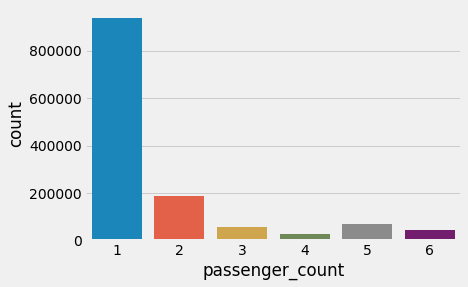

In [ ]:
try:
  df.drop('id',axis=1,inplace=True)                                             #this is of no use
except:
  pass
sns.countplot(df.passenger_count)

In [ ]:
# one_hot_entity='Passenger_count'    
# column_one_hot=['passenger_count']                # one hot encoding 
# count=0
# for i in column_one_hot:
#   temp_df=pd.get_dummies(df[i], prefix=one_hot_entity)
#   count+=1
#   try:
#     df_one_hot=pd.concat([df_one_hot, temp_df], axis=1)
#   except:
#     df_one_hot=temp_df
# df=pd.concat([df,df_one_hot], axis=1)
# df.drop('passenger_count',axis=1,inplace=True)
# df.head()

In [ ]:
list=['pickup_','dropoff_']
for i in list:  
  df[i+'date'] = df[i+'datetime'].dt.date
  df[i+'day'] = df[i+'datetime'].dt.day
  df[i+'month'] = df[i+'datetime'].dt.month
  df[i+'weekday'] = df[i+'datetime'].dt.weekday
  df[i+'weekofyear'] = df[i+'datetime'].dt.weekofyear
  df[i+'time'] = df[i+'datetime'].dt.hour

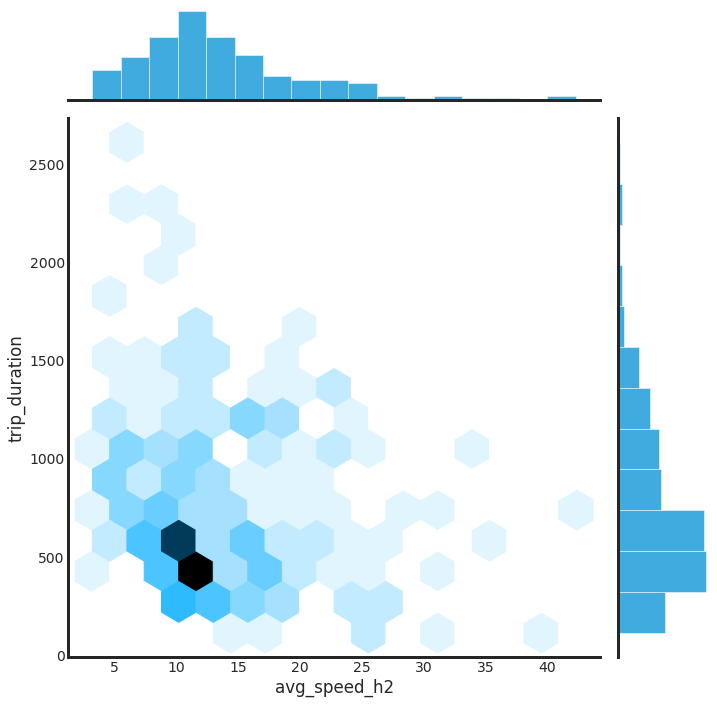

In [ ]:
df['avg_speed_h2']=df['haversine distance (km)']*3600  / df['trip_duration']    #converting sec to hours
with sns.axes_style('white'):
    sns.jointplot('avg_speed_h2', "trip_duration", df[:200], kind='hex',height=10)    
avg_speed_vs_hr=df.groupby('pickup_time')['avg_speed_h2'].mean()
avg_speed_vs_week=df.groupby('pickup_weekday')['avg_speed_h2'].mean()
avg_speed_vs_weekofyear=df.groupby('pickup_weekofyear')['avg_speed_h2'].mean()
avg_speed_vs_month=df.groupby('pickup_month')['avg_speed_h2'].mean()
avg_speed_vs_day=df.groupby('pickup_day')['avg_speed_h2'].mean()
avg_speed_vs_date=df.groupby('pickup_date')['avg_speed_h2'].mean()
dict_hr=dict(zip(avg_speed_vs_hr.index,avg_speed_vs_hr.values))
dict_week=dict(zip(avg_speed_vs_week.index,avg_speed_vs_week.values))
dict_weekofyear=dict(zip(avg_speed_vs_weekofyear.index,avg_speed_vs_weekofyear.values))
dict_month=dict(zip(avg_speed_vs_month.index,avg_speed_vs_month.values))
dict_day=dict(zip(avg_speed_vs_day.index,avg_speed_vs_day.values))

In [ ]:
df['avg_speed_hr']=df['pickup_time'].apply(lambda x:dict_hr[x])                            #now we can put this value in our model, and it will not create a baise.
df['avg_speed_hr']=np.log(df['avg_speed_hr'])
df['avg_speed_week']=df['pickup_weekday'].apply(lambda x:dict_week[x])                     #now we can put this value in our model, and it will not create a baise.
df['avg_speed_week']=np.log(df['avg_speed_week'])
df['avg_speed_weekofyear']=df['pickup_weekofyear'].apply(lambda x:dict_weekofyear[x])      #now we can put this value in our model, and it will not create a baise.
df['avg_speed_weekofyear']=np.log(df['avg_speed_weekofyear'])
df['avg_speed_month']=df['pickup_month'].apply(lambda x:dict_month[x])                     #now we can put this value in our model, and it will not create a baise.
df['avg_speed_month']=np.log(df['avg_speed_month'])
df['avg_speed_day']=df['pickup_day'].apply(lambda x:dict_day[x])                           #now we can put this value in our model, and it will not create a baise.
df['avg_speed_day']=np.log(df['avg_speed_day'])

In [ ]:
df['log_trip_duration']= np.log(df.trip_duration)                               #Normalizing the value of trip_duration
df['haversine distance (km)']= np.log(df['haversine distance (km)']) 
df['store_and_fwd_flag']=df.store_and_fwd_flag.apply(lambda x: np.where(x=='N',0,1))
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,haversine distance (km),pickup_date,pickup_day,pickup_month,pickup_weekday,pickup_weekofyear,pickup_time,dropoff_date,dropoff_day,dropoff_month,dropoff_weekday,dropoff_weekofyear,dropoff_time,avg_speed_h2,avg_speed_hr,avg_speed_week,avg_speed_weekofyear,avg_speed_month,avg_speed_day,log_trip_duration
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0.404480,2016-03-14,14,3,0,11,17,2016-03-14,14,3,0,11,17,11.856445,2.468857,2.639398,2.605848,2.615917,2.590675,6.120297
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,0.590843,2016-06-12,12,6,6,23,0,2016-06-12,12,6,6,23,0,9.803672,2.799641,2.748050,2.568794,2.579660,2.587801,6.496775
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1.853968,2016-01-19,19,1,1,3,11,2016-01-19,19,1,1,3,12,10.822216,2.451704,2.552406,2.592919,2.624709,2.602448,7.661056
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,0.395752,2016-04-06,6,4,2,14,19,2016-04-06,6,4,2,14,19,12.465738,2.551052,2.537605,2.584674,2.591475,2.610943,6.061457
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,0.172768,2016-03-26,26,3,5,12,13,2016-03-26,26,3,5,12,13,9.836608,2.444922,2.647987,2.641452,2.615917,2.583333,6.075346


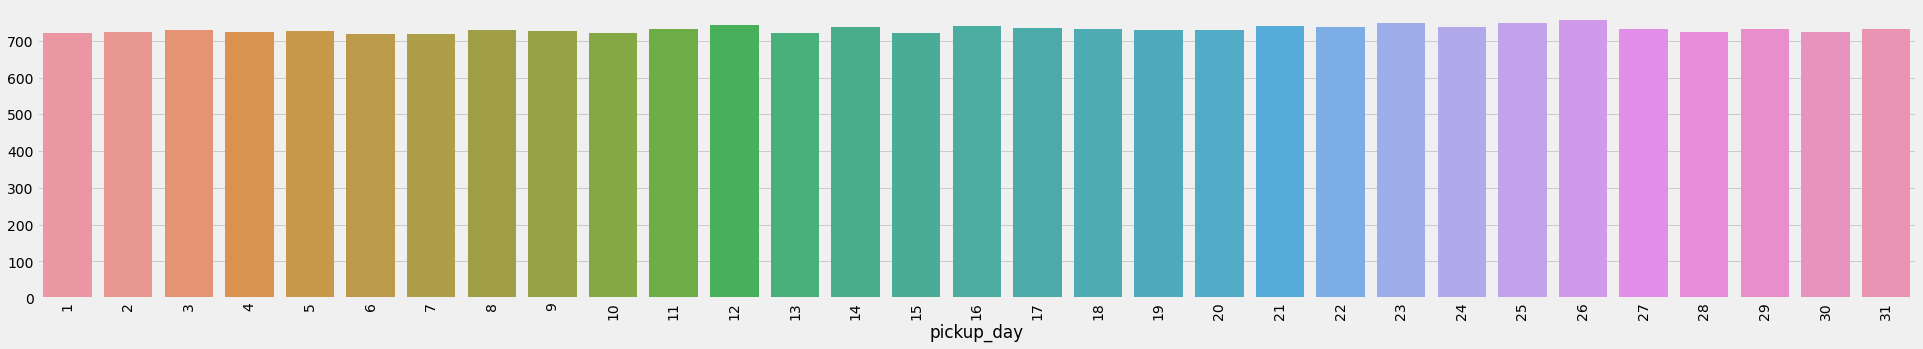

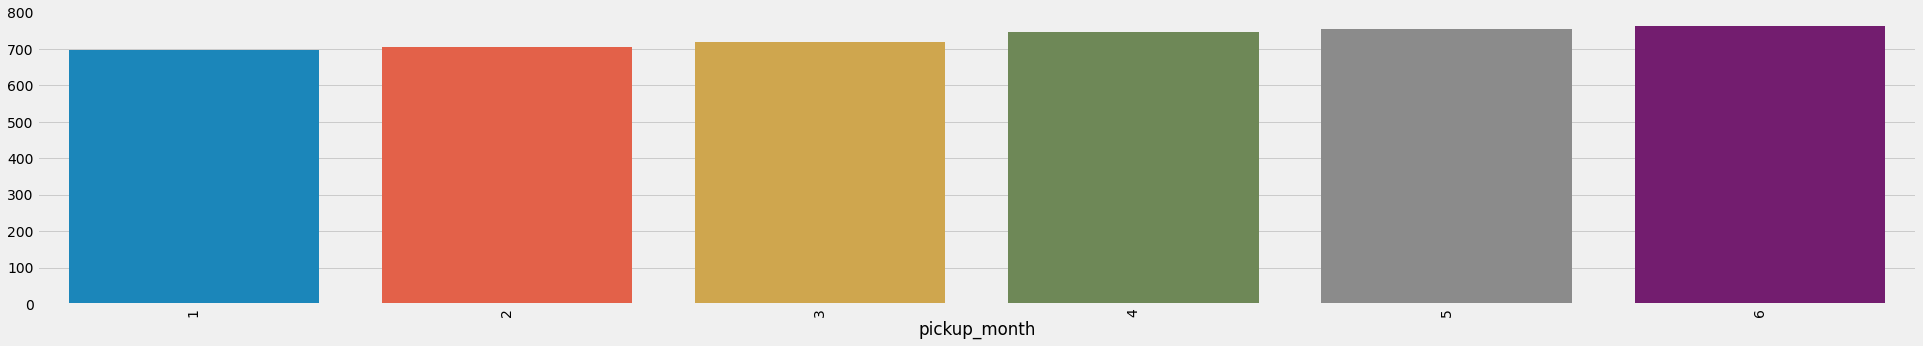

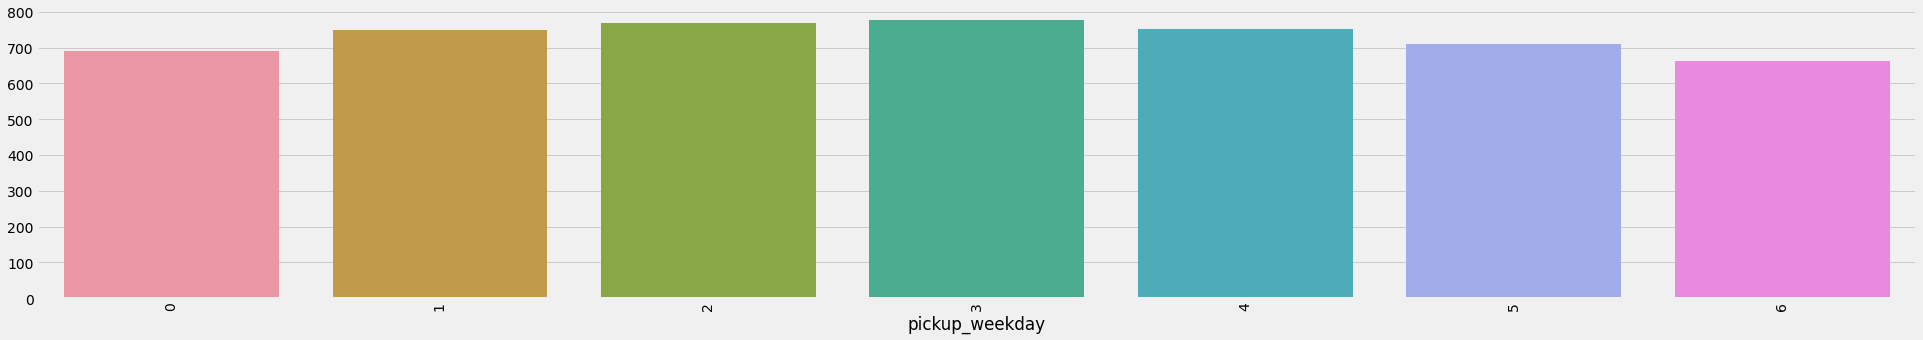

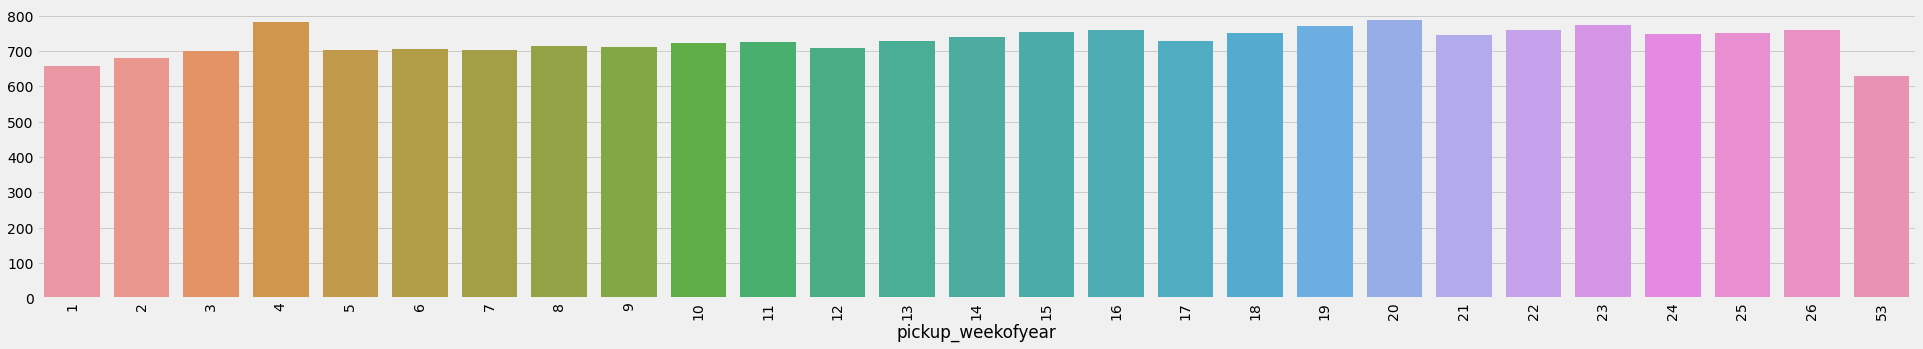

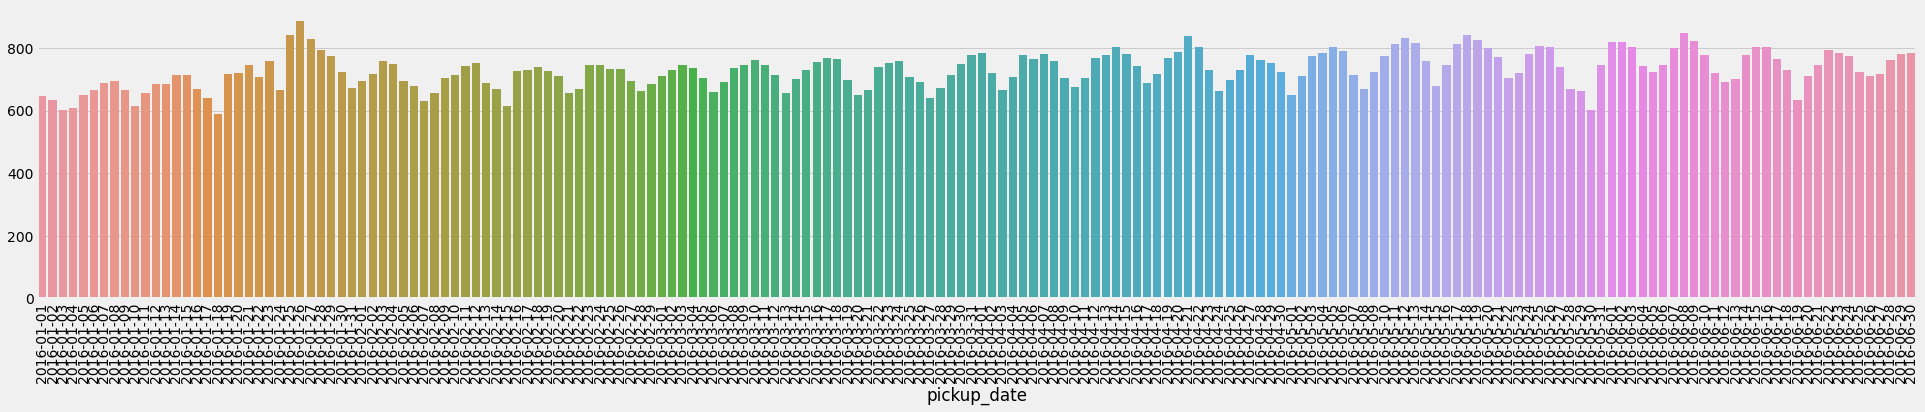

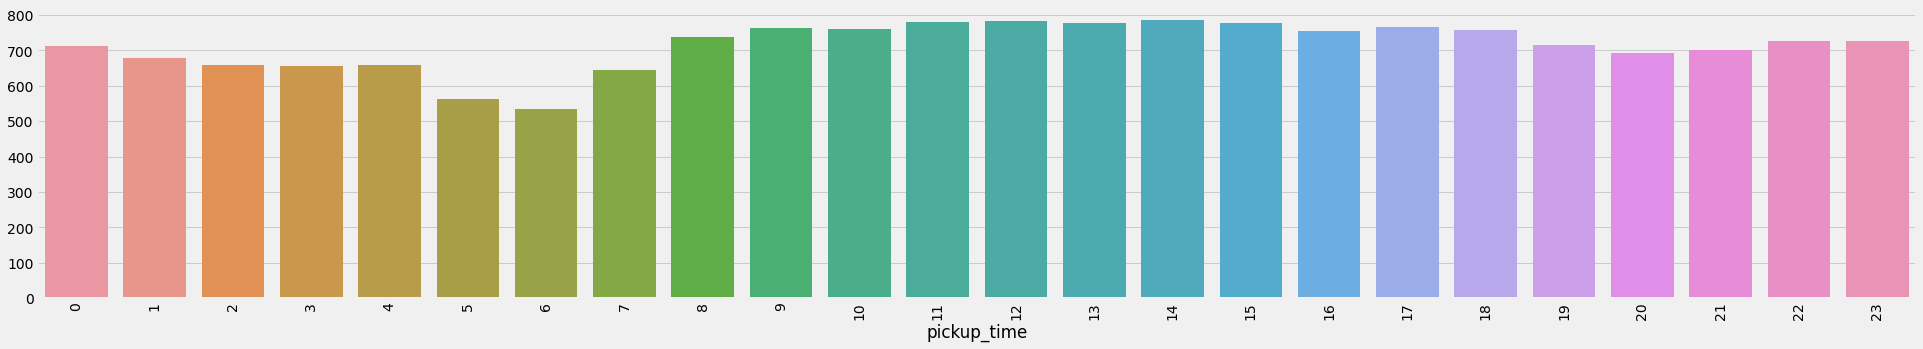

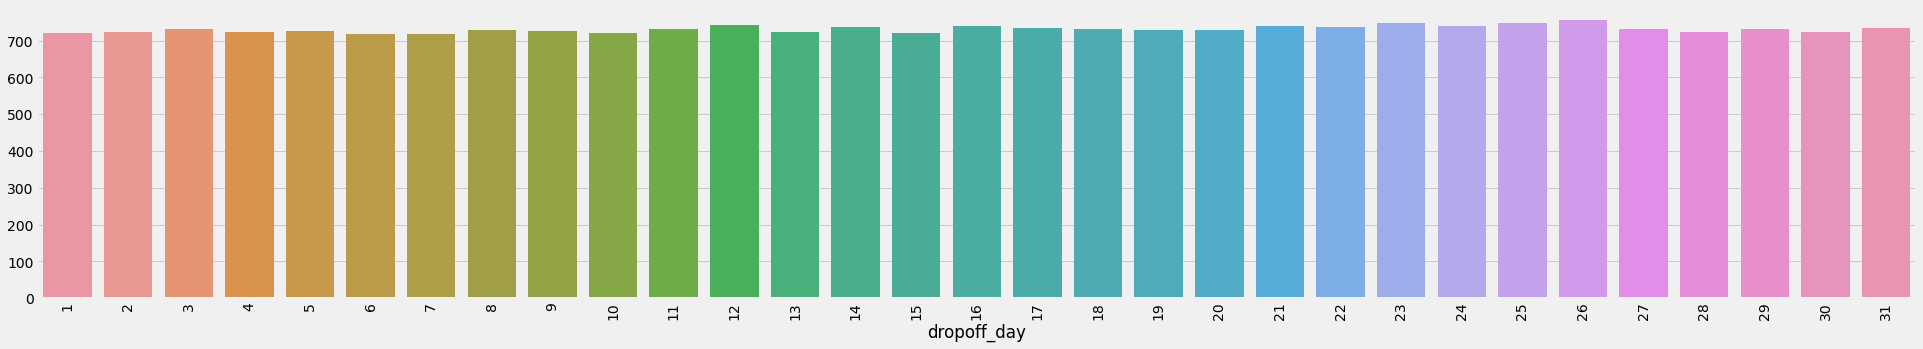

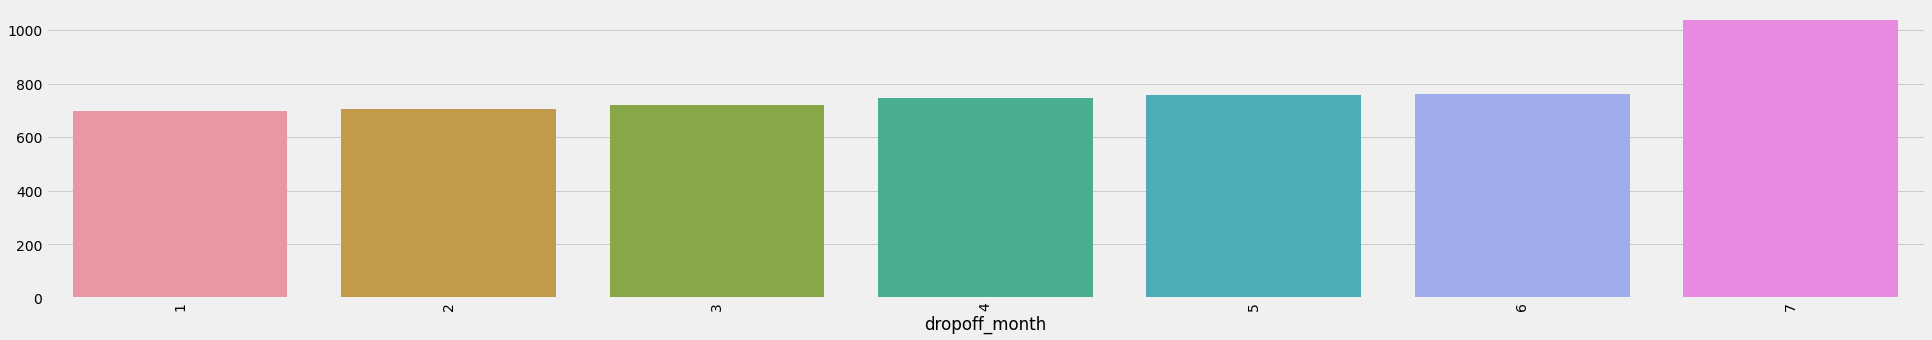

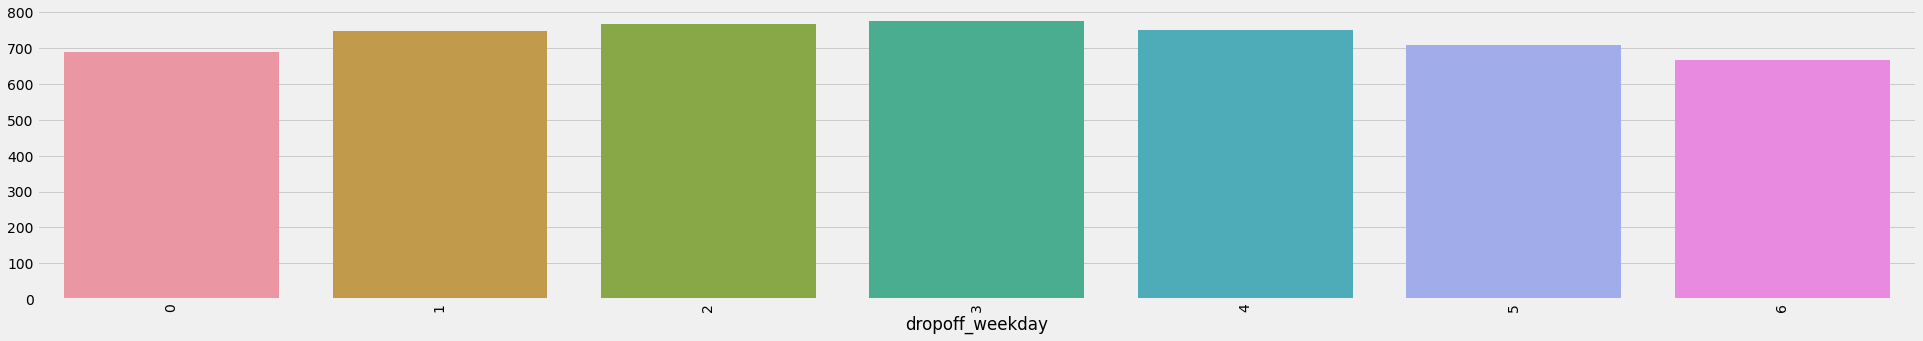

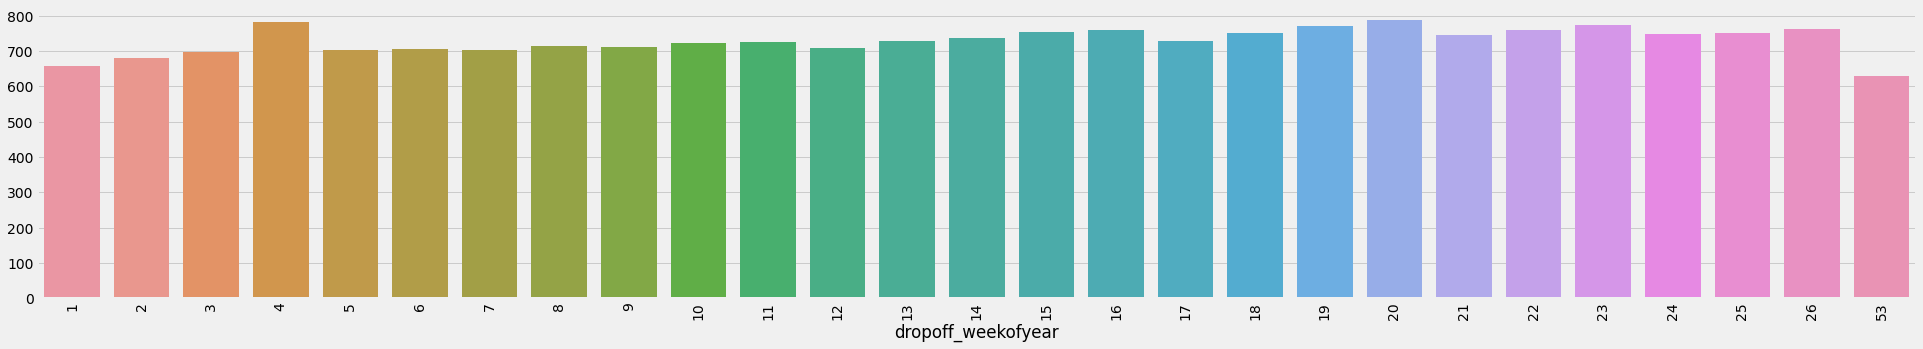

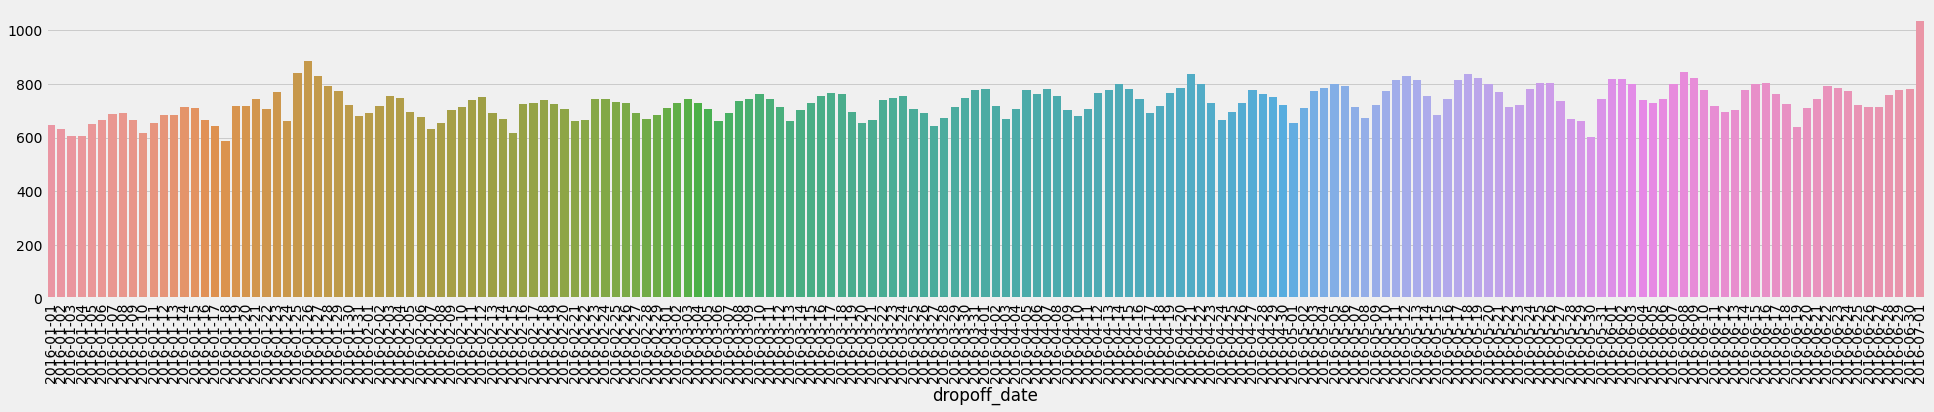

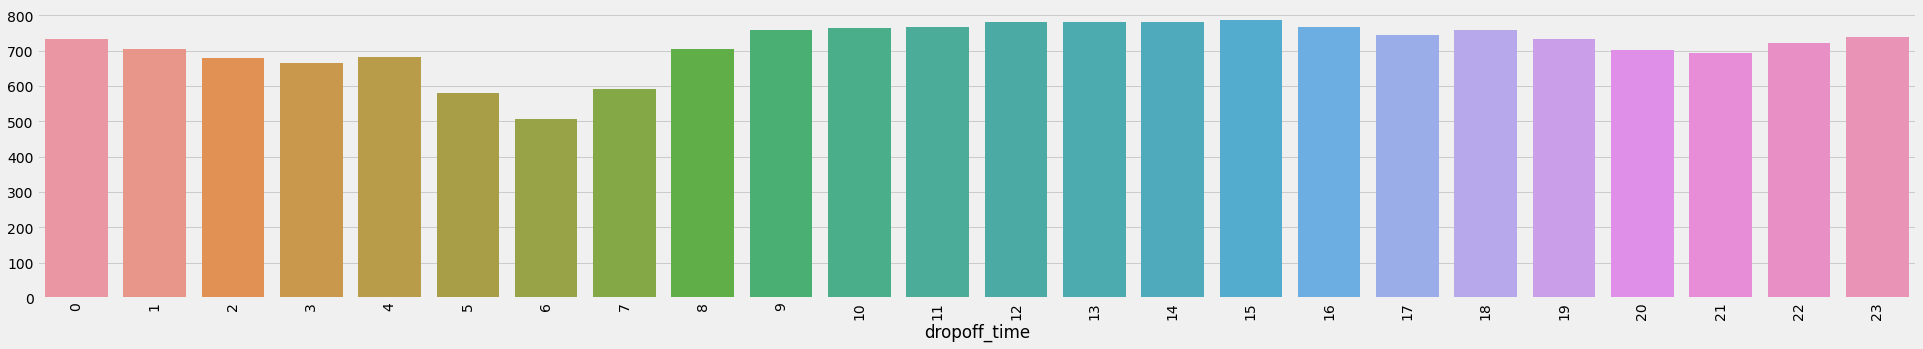

In [ ]:
list1=['day','month','weekday','weekofyear','date','time']
list2=['pickup_','dropoff_']
for i in list2:
  for j in list1:
    plt.figure(figsize=(30,5))
    temp=df.groupby(i+j)['trip_duration'].mean()
    sns.barplot(temp.index,temp.values)
    plt.xticks(rotation=90)
    plt.show()                                                                  # for all the time criteria trip durations are almost the same, except that of hours in a day, lets plot autocorelation chart to look for seasonality.

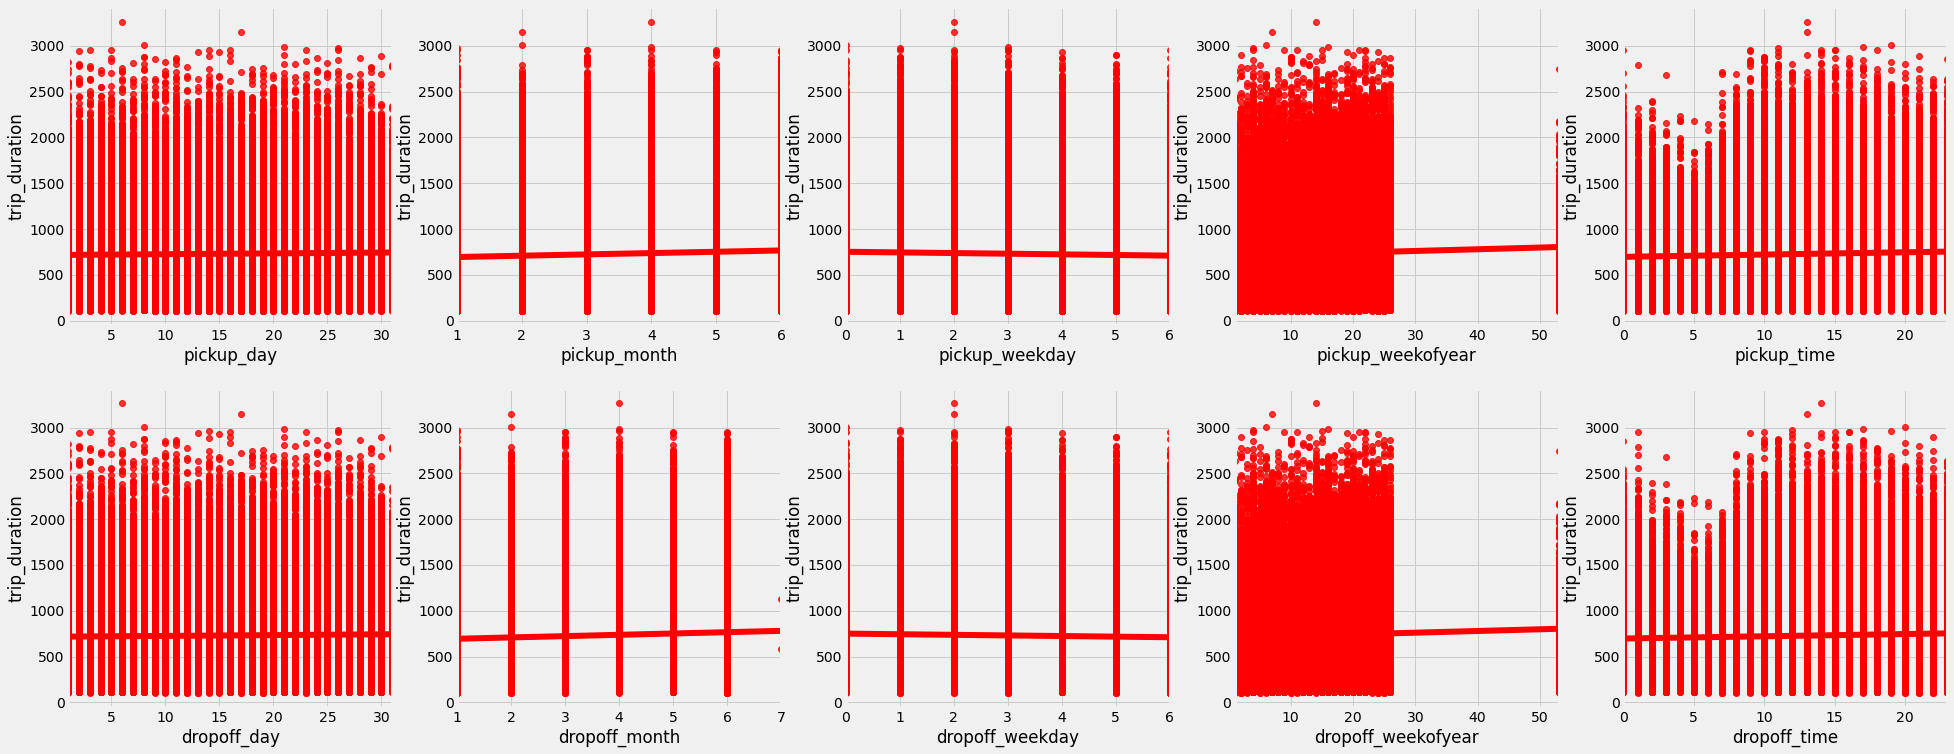

In [ ]:
time_attribute=['day','month','weekday','weekofyear','time']
service_nature=['pickup_','dropoff_']
count=0
counter=0
fig,ax=plt.subplots(2,5,figsize=(30,12))
plt.rcParams['axes.facecolor'] = 'black'
for service in service_nature:
  if counter==5:
    count=1
    counter=0
  for attribute in time_attribute:
    sns.regplot(df[service+attribute][:100000],df.trip_duration[:100000],color='red',ax=ax[count,counter])
    
    counter+=1                                                                  # Reg plot shows the linear relationship between trip duration and all the time formats.                                        

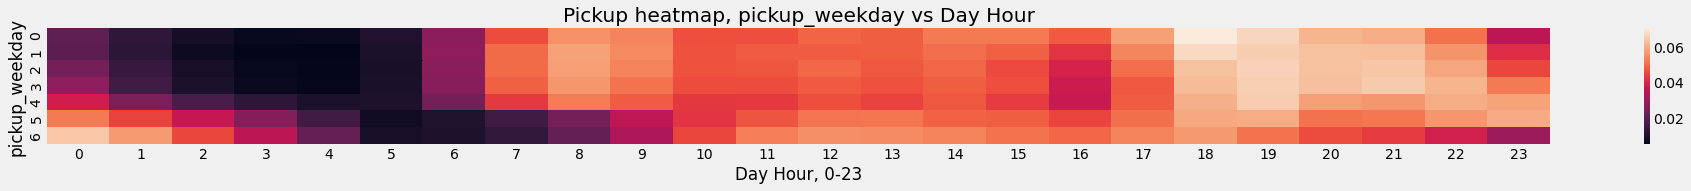

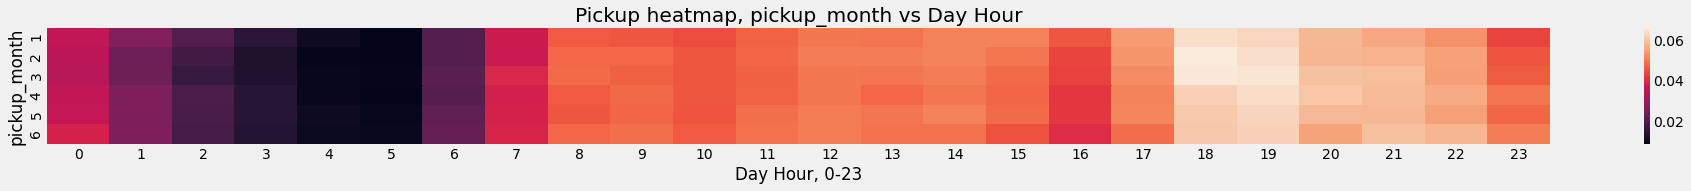

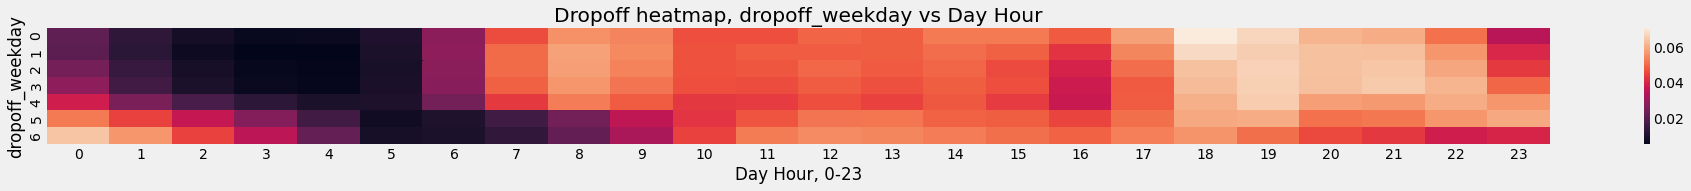

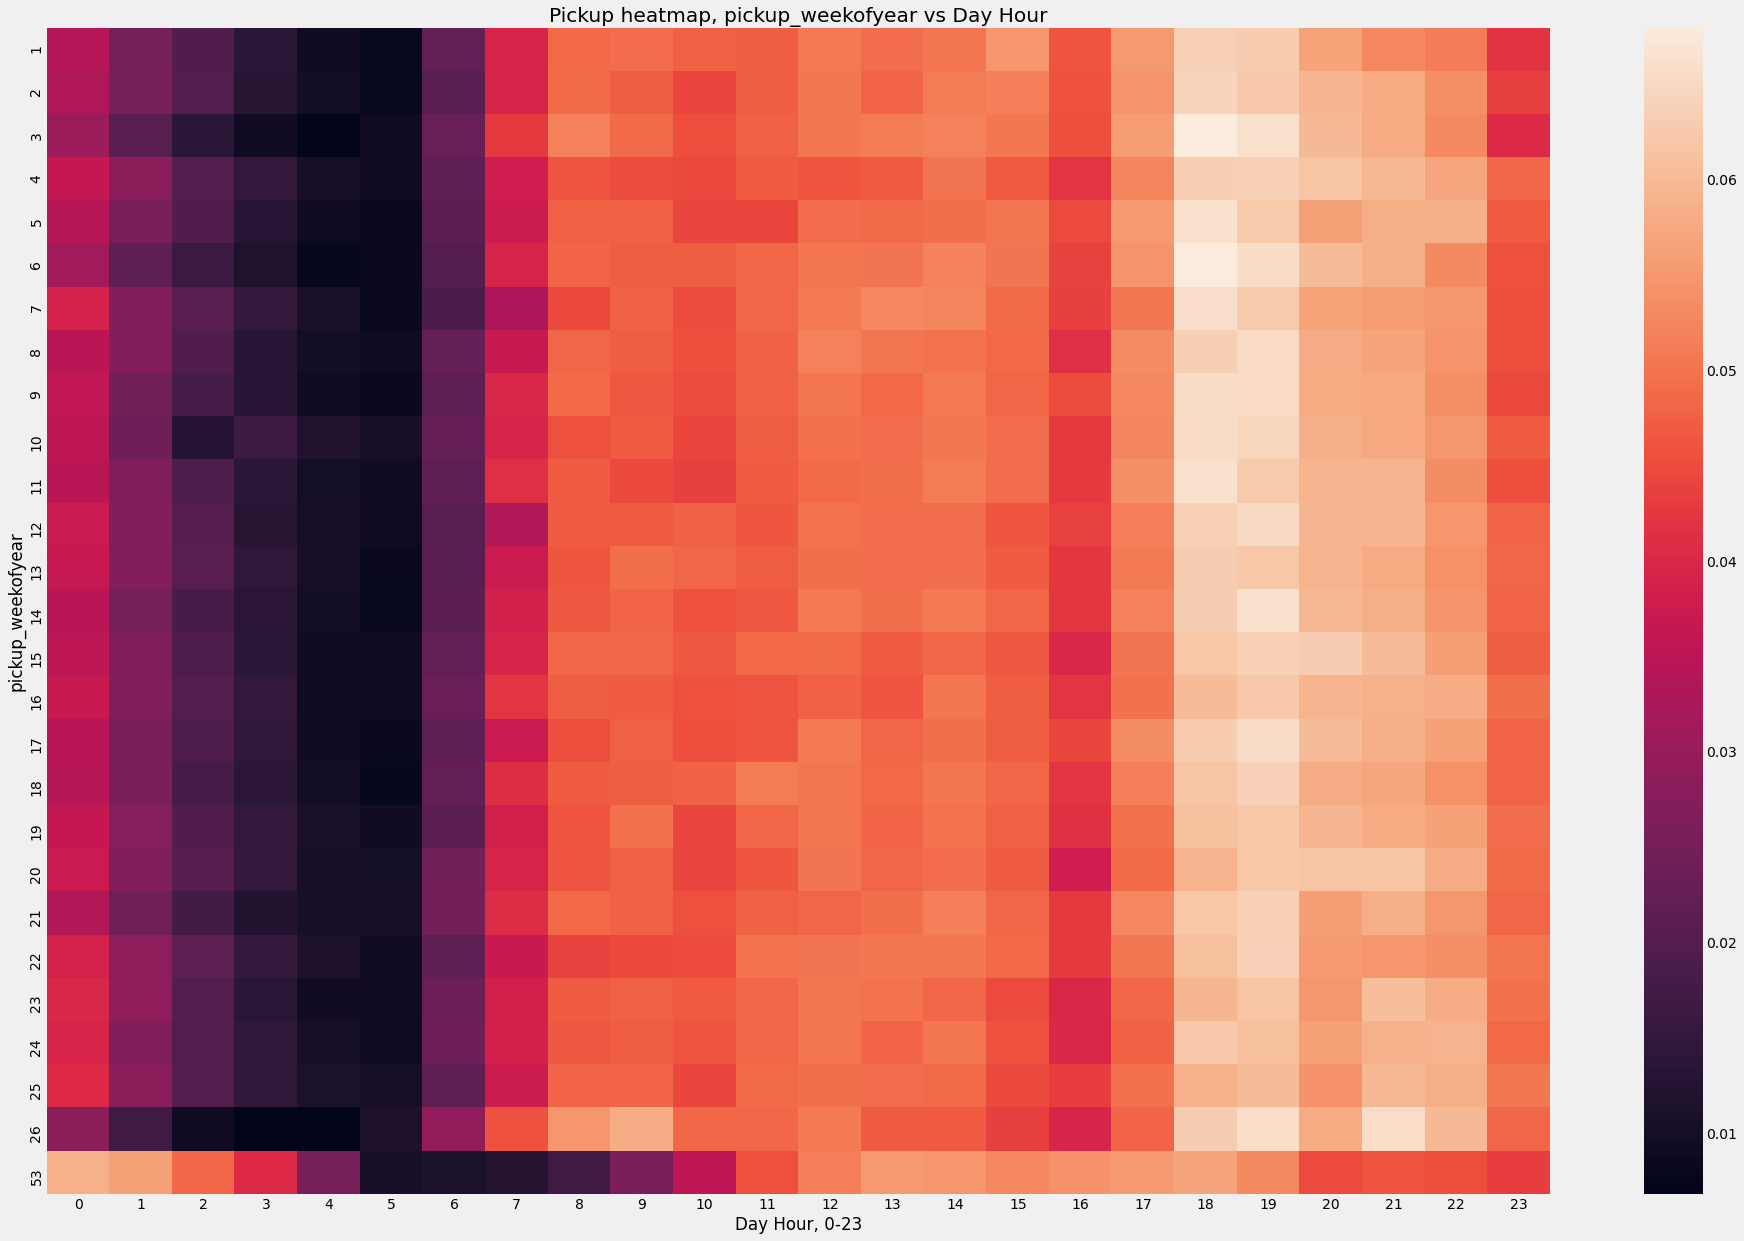

In [ ]:
plot_list=['pickup_weekday','pickup_month','dropoff_weekday','pickup_weekofyear']
count=0
for i in plot_list:
  count+=1
  if count==4:
    plt.figure(figsize=(30,20))
  else:
    plt.figure(figsize=(30,2))
  sns.heatmap(data=pd.crosstab(df[i], 
                              df.pickup_time, 
                              values=df.vendor_id, 
                              aggfunc='count',
                              normalize='index'))
  if count==3:
    plt.title(f'Dropoff heatmap, {i} vs Day Hour')
    plt.ylabel(i) ; plt.xlabel('Day Hour, 0-23')
    
    plt.show()
  else:
    plt.title(f'Pickup heatmap, {i} vs Day Hour')
    plt.ylabel(i) ; plt.xlabel('Day Hour, 0-23')
    
    
    plt.show()                                                                    #Both heat maps tells the similar story, 6-7pm are the peak times, and nights hardly have any bookings.

In [ ]:
df.drop(['avg_speed_h2'],axis=1,inplace=True)

In [ ]:
df.drop(['pickup_datetime','dropoff_datetime','trip_duration','pickup_date','dropoff_date','dropoff_day','dropoff_month','dropoff_weekday','dropoff_weekofyear','dropoff_time'],axis=1,inplace=True)

In [ ]:
df['lat_diff']=df.dropoff_latitude-df.pickup_latitude
df['long_diff']=df.dropoff_longitude-df.pickup_longitude                        # west yeild -ve on long_diff, vice versa & north yeild + lat_diff and vice versa, thus we can now give directions.
# df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)

In [ ]:
df['North']=df['lat_diff'].apply(lambda x: np.where(x>0,1,0))
df['South']=df['lat_diff'].apply(lambda x: np.where(x<0,1,0))
df['West']=df['long_diff'].apply(lambda x: np.where(x<0,1,0))
df['East']=df['long_diff'].apply(lambda x: np.where(x>0,1,0))

df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,haversine distance (km),pickup_day,pickup_month,pickup_weekday,pickup_weekofyear,pickup_time,avg_speed_hr,avg_speed_week,avg_speed_weekofyear,avg_speed_month,avg_speed_day,log_trip_duration,lat_diff,long_diff,North,South,West,East
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,0.404480,14,3,0,11,17,2.468857,2.639398,2.605848,2.615917,2.590675,6.120297,-0.002335,0.017525,0,1,0,1
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,0.590843,12,6,6,23,0,2.799641,2.748050,2.568794,2.579660,2.587801,6.496775,-0.007412,-0.019066,0,1,1,0
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,1.853968,19,1,1,3,11,2.451704,2.552406,2.592919,2.624709,2.602448,7.661056,-0.053852,-0.026306,0,1,1,0
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,0.395752,6,4,2,14,19,2.551052,2.537605,2.584674,2.591475,2.610943,6.061457,-0.013252,-0.002228,0,1,1,0
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,0.172768,26,3,5,12,13,2.444922,2.647987,2.641452,2.615917,2.583333,6.075346,-0.010689,0.000130,0,1,0,1


In [ ]:
# column_one_hot=['pickup_time','pickup_weekofyear','pickup_weekday','pickup_month','pickup_day','vendor_id']                # one hot encoding 
# for i in column_one_hot:
#   temp2_df=pd.get_dummies(df[i], prefix=i)
#   try:
#     df_one_hot2=pd.concat([df_one_hot2, temp2_df], axis=1)
#   except:
#     df_one_hot2=temp2_df

In [ ]:
# df=pd.concat([df,df_one_hot2], axis=1)
# df.drop(['pickup_time','pickup_weekofyear','pickup_weekday','pickup_month','pickup_day','vendor_id','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)

In [ ]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,haversine distance (km),pickup_day,pickup_month,pickup_weekday,pickup_weekofyear,pickup_time,avg_speed_hr,avg_speed_week,avg_speed_weekofyear,avg_speed_month,avg_speed_day,log_trip_duration,lat_diff,long_diff,North,South,West,East
0,2,1,-73.982,40.768,-73.965,40.766,0,0.404,14,3,0,11,17,2.469,2.639,2.606,2.616,2.591,6.120,-0.002,0.018,0,1,0,1
1,1,1,-73.980,40.739,-73.999,40.731,0,0.591,12,6,6,23,0,2.800,2.748,2.569,2.580,2.588,6.497,-0.007,-0.019,0,1,1,0
2,2,1,-73.979,40.764,-74.005,40.710,0,1.854,19,1,1,3,11,2.452,2.552,2.593,2.625,2.602,7.661,-0.054,-0.026,0,1,1,0
3,2,1,-74.010,40.720,-74.012,40.707,0,0.396,6,4,2,14,19,2.551,2.538,2.585,2.591,2.611,6.061,-0.013,-0.002,0,1,1,0
4,2,1,-73.973,40.793,-73.973,40.783,0,0.173,26,3,5,12,13,2.445,2.648,2.641,2.616,2.583,6.075,-0.011,0.000,0,1,0,1


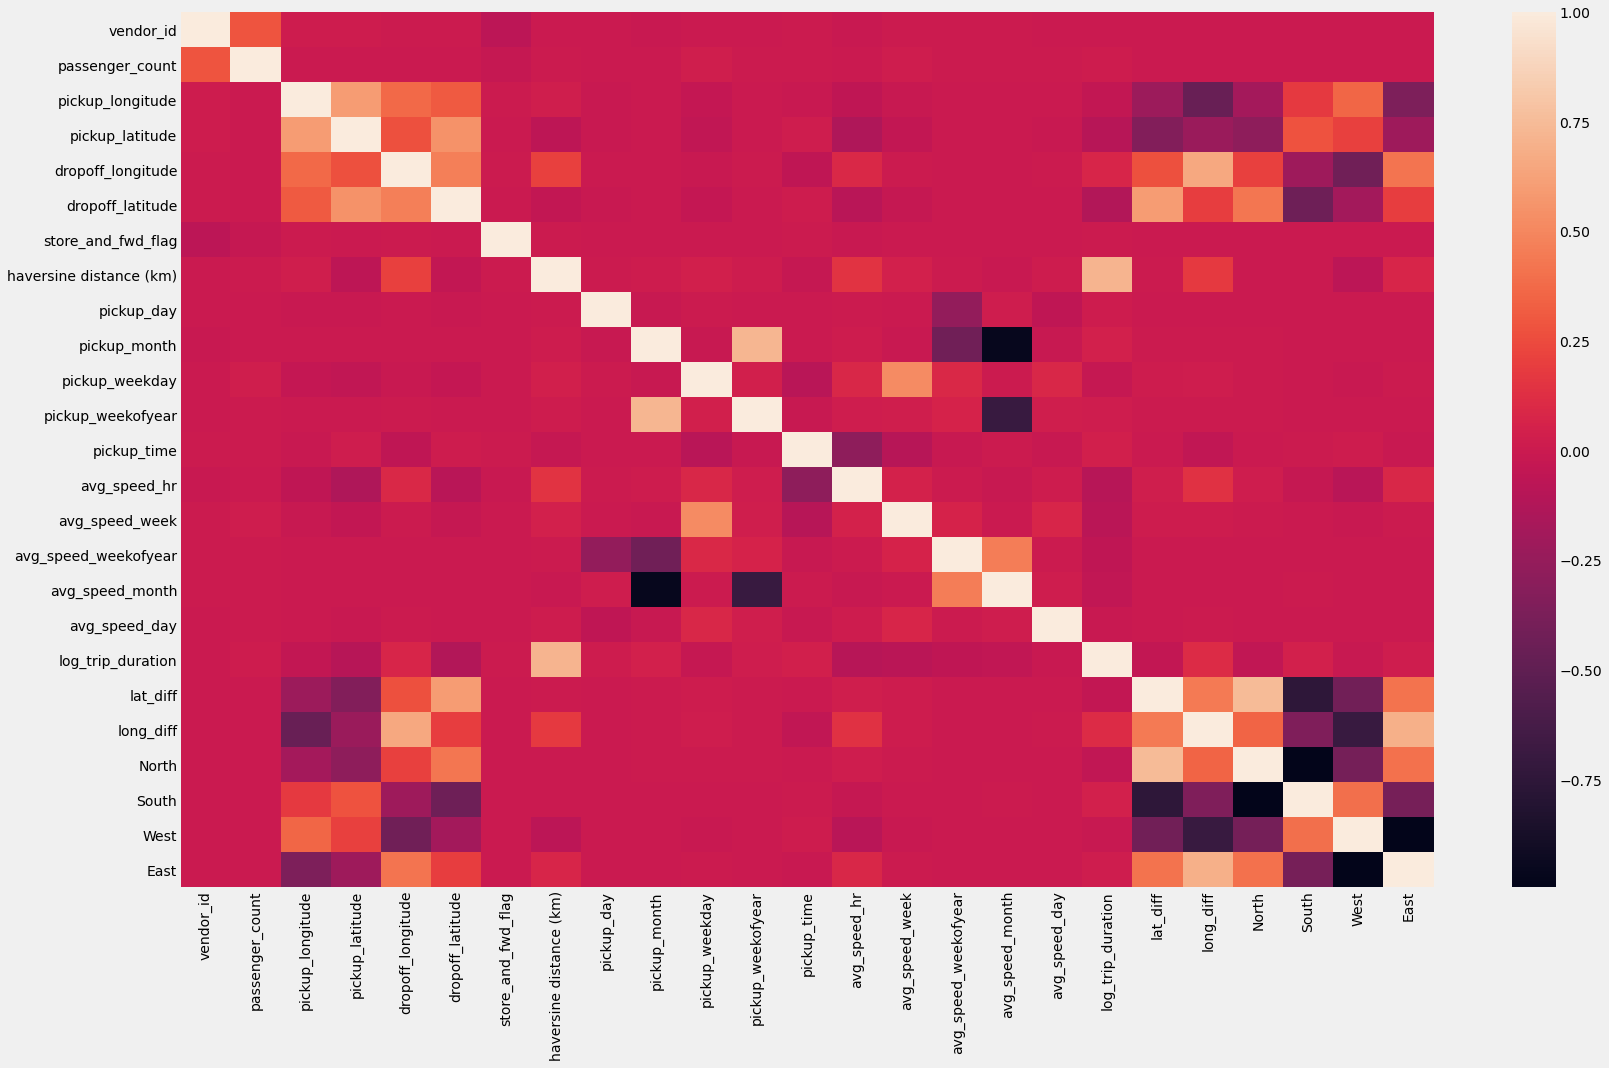

In [ ]:
corr =df.corr()                                                                #plotting co-relation chart
plt.figure(figsize=(25,15))
sns.heatmap(corr, annot=False)
plt.show()   

In [24]:
X=df.drop('log_trip_duration',axis=1)[:100000]
y=df['log_trip_duration'][:100000]
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.05)
X_train, X_val, y_train, y_val= train_test_split(X_train,y_train,test_size=0.1)

In [ ]:
from sklearn.model_selection import GridSearchCV  
xgb_model = XGBRegressor()
learning_rate= [0.1,0.25,0.5]                                                   # various learning rates i will tryout
nax_depth = [10,12]      
n_estimators=[100,200,300]                                                      # various depths that i will try out
parameters = dict(learning_rate=learning_rate, nax_depth=nax_depth, n_estimators=n_estimators,objective=['reg:squarederror'])     
grid = GridSearchCV(xgb_model,parameters,scoring='r2', cv=None)                 # we can also use 'neg_mean_squared_error', here i am not using cv as dataset is quite large and well distributed.
grid_result=grid.fit(X_train, y_train)
print ("r2 / variance : ", grid.best_score_,'with parameter: ',grid_result.best_params_)
print("RMSE score: %.2f"
              % np.sqrt(metrics.mean_squared_error(y_test,grid.predict(X_test))))

As, Dataset is quite huge, using Kfold Cross-Validation and gridsearch was impossible due to hardware constraints, thus i decided to change values on by own by running model and looking at result multiple times.

In [ ]:
# model = XGBRegressor(max_depth=10,                                             
#                      learning_rate=0.08,
#                      n_estimators=150,
#                      verbosity=0,
#                      objective='reg:squarederror')                                                         
# model.fit(X_train,y_train)
# y_pred_test=model.predict(X_test)
# y_pred_train=model.predict(X_train)
# print(r2_score(y_test,y_pred_test))
# print('RMSE score for the CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_test))))
# print(r2_score(y_train,y_pred_train))
# print('RMSE score for the CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_train))))
# #Wow 97% r2 Score

this was the best accuracy i was able to achieve using XGBoost model, after switching various Hyperparameters.

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)  #Sort the DataFrame in order decreasing feature importance
    plt.figure(figsize=(30,8))
    sns.barplot(y=fi_df['feature_importance'], x=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.xticks(rotation=90)
    plt.ylabel('FEATURE NAMES')

In [ ]:
# plot_feature_importance(model.feature_importances_,X_train.columns,'XG BOOST')#Plotting Feature Importance for XGboost

#HyperParameter Tuning for CatBoost Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV  
cat_model = CatBoostRegressor()
learning_rate= [0.005,0.01,0.05]                                                   # various learning rates i will tryout
depth = [10,12]                                                                 # various depths that i will try out
parameters = dict(depth=depth,learning_rate=learning_rate,iterations=[1000],    # max iterations are set to 1000 
                  od_type=["Iter"],od_wait=[200],metric_period=[999],           # i have used overfitting detector & enables the use of best model
                  use_best_model = [True] )     
grid = GridSearchCV(cat_model,parameters,scoring='r2', cv=None)                 #we can also use 'neg_mean_squared_error', here i am not using cv as dataset is quite large and well distributed.
grid_result=grid.fit(X_train, y_train, eval_set=(X_val,y_val))
print ("r2 / variance : ", grid.best_score_,'with parameter: ',grid_result.best_params_)
print("RMSE score: %.2f"
              % np.sqrt(metrics.mean_squared_error(y_test,grid.predict(X_test))))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 0.6187139	test: 0.6221044	best: 0.6221044 (0)	total: 45.7ms	remaining: 45.7s
999:	learn: 0.2385143	test: 0.3029382	best: 0.3029240 (996)	total: 39.9s	remaining: 0us

bestTest = 0.3029240287
bestIteration = 996

Shrink model to first 997 iterations.


0:	learn: 0.6198170	test: 0.6220018	best: 0.6220018 (0)	total: 41.2ms	remaining: 41.1s
999:	learn: 0.2389273	test: 0.3039556	best: 0.3039556 (999)	total: 39.7s	remaining: 0us

bestTest = 0.3039555827
bestIteration = 999



0:	learn: 0.6194552	test: 0.6217690	best: 0.6217690 (0)	total: 43.5ms	remaining: 43.5s
999:	learn: 0.2377049	test: 0.3036717	best: 0.3036717 (999)	total: 40.1s	remaining: 0us

bestTest = 0.3036716876
bestIteration = 999



0:	learn: 0.6197426	test: 0.6217801	best: 0.6217801 (0)	total: 39.4ms	remaining: 39.3s
999:	learn: 0.2395348	test: 0.3038290	best: 0.3038052 (992)	total: 40.1s	remaining: 0us

bestTest = 0.3038051942
bestIteration = 992

Shrink model to first 993 iterations.


0:	learn: 0.6181144	test: 0.6220784	best: 0.6220784 (0)	total: 38.8ms	remaining: 38.8s
999:	learn: 0.2385706	test: 0.3034771	best: 0.3034087 (969)	total: 39.7s	remaining: 0us

bestTest = 0.3034086699
bestIteration = 969

Shrink model to first 970 iterations.


0:	learn: 0.6005847	test: 0.6038339	best: 0.6038339 (0)	total: 39.9ms	remaining: 39.9s
999:	learn: 0.1918070	test: 0.3034052	best: 0.3033830 (995)	total: 39.9s	remaining: 0us

bestTest = 0.3033829999
bestIteration = 995

Shrink model to first 996 iterations.


0:	learn: 0.6015802	test: 0.6036600	best: 0.6036600 (0)	total: 41.7ms	remaining: 41.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3048336263
bestIteration = 779

Shrink model to first 780 iterations.


0:	learn: 0.6010607	test: 0.6032131	best: 0.6032131 (0)	total: 39.3ms	remaining: 39.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3046504315
bestIteration = 637

Shrink model to first 638 iterations.


0:	learn: 0.6013733	test: 0.6032133	best: 0.6032133 (0)	total: 39.5ms	remaining: 39.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3045788315
bestIteration = 592

Shrink model to first 593 iterations.


0:	learn: 0.6000040	test: 0.6038257	best: 0.6038257 (0)	total: 40ms	remaining: 39.9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3036877194
bestIteration = 577

Shrink model to first 578 iterations.


0:	learn: 0.4758419	test: 0.4775822	best: 0.4775822 (0)	total: 39.8ms	remaining: 39.8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3156914582
bestIteration = 80

Shrink model to first 81 iterations.
0:	learn: 0.4760173	test: 0.4770310	best: 0.4770310 (0)	total: 39.5ms	remaining: 39.4s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.315898821
bestIteration = 80

Shrink model to first 81 iterations.


0:	learn: 0.4744243	test: 0.4750746	best: 0.4750746 (0)	total: 49.8ms	remaining: 49.8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3188912309
bestIteration = 51

Shrink model to first 52 iterations.
0:	learn: 0.4749460	test: 0.4749896	best: 0.4749896 (0)	total: 40.3ms	remaining: 40.3s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3177644604
bestIteration = 61

Shrink model to first 62 iterations.
0:	learn: 0.4753913	test: 0.4777219	best: 0.4777219 (0)	total: 40.3ms	remaining: 40.3s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3176870947
bestIteration = 70

Shrink model to first 71 iterations.


0:	learn: 0.6186239	test: 0.6220469	best: 0.6220469 (0)	total: 119ms	remaining: 1m 58s
999:	learn: 0.1849599	test: 0.3047356	best: 0.3047048 (984)	total: 1m 49s	remaining: 0us

bestTest = 0.3047048375
bestIteration = 984

Shrink model to first 985 iterations.


0:	learn: 0.6197372	test: 0.6219573	best: 0.6219573 (0)	total: 111ms	remaining: 1m 50s
999:	learn: 0.1860923	test: 0.3055734	best: 0.3055734 (999)	total: 1m 49s	remaining: 0us

bestTest = 0.30557337
bestIteration = 999



0:	learn: 0.6193162	test: 0.6216331	best: 0.6216331 (0)	total: 108ms	remaining: 1m 47s
999:	learn: 0.1858060	test: 0.3057193	best: 0.3056859 (934)	total: 1m 48s	remaining: 0us

bestTest = 0.305685944
bestIteration = 934

Shrink model to first 935 iterations.


0:	learn: 0.6196092	test: 0.6216417	best: 0.6216417 (0)	total: 108ms	remaining: 1m 48s
999:	learn: 0.1871763	test: 0.3051778	best: 0.3051778 (999)	total: 1m 49s	remaining: 0us

bestTest = 0.3051777868
bestIteration = 999



0:	learn: 0.6180314	test: 0.6220289	best: 0.6220289 (0)	total: 108ms	remaining: 1m 47s
999:	learn: 0.1855967	test: 0.3048876	best: 0.3047928 (965)	total: 1m 48s	remaining: 0us

bestTest = 0.3047928117
bestIteration = 965

Shrink model to first 966 iterations.


0:	learn: 0.6003944	test: 0.6037125	best: 0.6037125 (0)	total: 120ms	remaining: 1m 59s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3054797478
bestIteration = 508

Shrink model to first 509 iterations.


0:	learn: 0.6014107	test: 0.6035640	best: 0.6035640 (0)	total: 107ms	remaining: 1m 46s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3071285767
bestIteration = 448

Shrink model to first 449 iterations.


0:	learn: 0.6007753	test: 0.6029363	best: 0.6029363 (0)	total: 112ms	remaining: 1m 52s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3075232695
bestIteration = 467

Shrink model to first 468 iterations.


0:	learn: 0.6010994	test: 0.6029305	best: 0.6029305 (0)	total: 112ms	remaining: 1m 52s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3080147193
bestIteration = 528

Shrink model to first 529 iterations.


0:	learn: 0.5998282	test: 0.6037201	best: 0.6037201 (0)	total: 109ms	remaining: 1m 49s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3076589204
bestIteration = 500

Shrink model to first 501 iterations.


0:	learn: 0.4744036	test: 0.4766665	best: 0.4766665 (0)	total: 110ms	remaining: 1m 50s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3206828793
bestIteration = 46

Shrink model to first 47 iterations.


0:	learn: 0.4746872	test: 0.4761986	best: 0.4761986 (0)	total: 112ms	remaining: 1m 51s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3206965112
bestIteration = 52

Shrink model to first 53 iterations.


0:	learn: 0.4726815	test: 0.4734905	best: 0.4734905 (0)	total: 111ms	remaining: 1m 50s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.321399983
bestIteration = 42

Shrink model to first 43 iterations.


0:	learn: 0.4732654	test: 0.4733278	best: 0.4733278 (0)	total: 110ms	remaining: 1m 49s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3234576335
bestIteration = 53

Shrink model to first 54 iterations.


0:	learn: 0.4740347	test: 0.4768801	best: 0.4768801 (0)	total: 112ms	remaining: 1m 52s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3211590408
bestIteration = 43

Shrink model to first 44 iterations.


0:	learn: 0.6191093	test: 0.6218652	best: 0.6218652 (0)	total: 49ms	remaining: 48.9s
999:	learn: 0.2474672	test: 0.3011035	best: 0.3010935 (993)	total: 44.5s	remaining: 0us

bestTest = 0.3010935464
bestIteration = 993

Shrink model to first 994 iterations.
r2 / variance :  0.7700367392179813 with parameter:  {'depth': 10, 'iterations': 1000, 'learning_rate': 0.05, 'metric_period': 999, 'od_type': 'Iter', 'od_wait': 200, 'use_best_model': True}
RMSE score: 0.31


In [ ]:
X=df.drop('log_trip_duration',axis=1)
y=df['log_trip_duration']
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.05)
X_train, X_val, y_train, y_val= train_test_split(X_train,y_train,test_size=0.1)

In [ ]:
cat_model = CatBoostRegressor(loss_function = "RMSE", eval_metric = "RMSE", metric_period = 1000, iterations=30000,
                        use_best_model = True,
                        random_strength = 0.005,
                        learning_rate=lr,
                        depth=8,
                        random_seed = 93,
                        l2_leaf_reg = 0.1,
                        verbose=True,
                        logging_level = None,od_type = "Iter",
                        od_wait = 200)
cat_model.fit( X_train, y_train, cat_features=None, eval_set=(X_val,y_val))
y_pred_test_cat=cat_model.predict(X_test)
y_pred_train_cat=cat_model.predict(X_train)
print(f'For learning rate = {lr}, following are the scores of evaluation metrics:')
print(f'r2 score for test set using  CatRegressor is : {r2_score(y_test,y_pred_test_cat)}')
print('RMSE score for test set using CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_test_cat))))
print(f'r2 score for train set using CatRegressor is : {r2_score(y_train,y_pred_train_cat)}')
print('RMSE score for train set using CatRegressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_train_cat))))
# we are able to achieve 80 percent r2 score using this model  

0:	learn: 0.5999066	test: 0.5987996	best: 0.5987996 (0)	total: 199ms	remaining: 1h 39m 16s
1000:	learn: 0.2869203	test: 0.2914935	best: 0.2914935 (1000)	total: 3m 1s	remaining: 1h 27m 50s
2000:	learn: 0.2759969	test: 0.2856278	best: 0.2856278 (2000)	total: 6m 2s	remaining: 1h 24m 32s
3000:	learn: 0.2686870	test: 0.2830553	best: 0.2830553 (3000)	total: 9m 2s	remaining: 1h 21m 20s
4000:	learn: 0.2629258	test: 0.2813030	best: 0.2813030 (4000)	total: 12m 2s	remaining: 1h 18m 17s
5000:	learn: 0.2579950	test: 0.2803053	best: 0.2803053 (5000)	total: 15m 2s	remaining: 1h 15m 13s
6000:	learn: 0.2535512	test: 0.2795895	best: 0.2795882 (5994)	total: 18m 1s	remaining: 1h 12m 3s
7000:	learn: 0.2495563	test: 0.2790314	best: 0.2790270 (6977)	total: 20m 59s	remaining: 1h 8m 56s
8000:	learn: 0.2457805	test: 0.2785705	best: 0.2785705 (8000)	total: 23m 57s	remaining: 1h 5m 53s
9000:	learn: 0.2423041	test: 0.2782130	best: 0.2782088 (8996)	total: 26m 57s	remaining: 1h 2m 54s
10000:	learn: 0.2390930	test: 0

this model is not only fast but much more accurate as well.

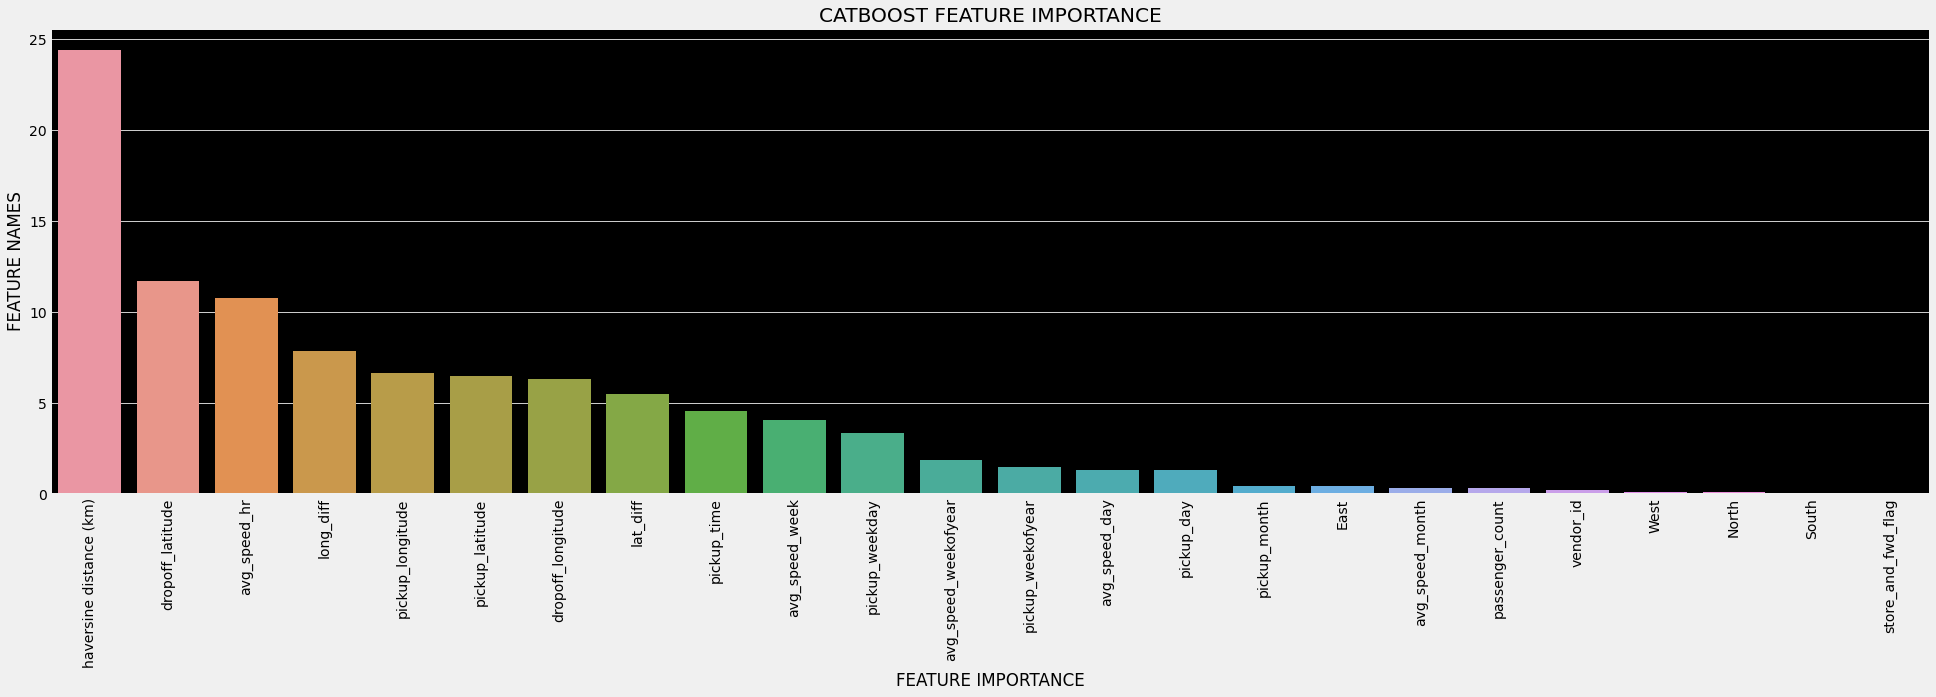

In [ ]:
plot_feature_importance(cat_model.get_feature_importance(),X_train.columns,'CATBOOST ') #Plotting Feature Importance for CatBoost Model